In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline


loan = pd.read_csv('accepted_2007_to_2018Q4.csv')

return_number = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

def convert_date(d):
    try:
        return datetime.date(year=int(d[4:]), month=return_number[d[:3]], day=1)
    except:
        pass

loan['issue_d'] = loan['issue_d'].apply(convert_date)
loan['earliest_cr_line'] = loan['earliest_cr_line'].apply(convert_date)

loan = loan[loan.issue_d < datetime.date(2015,7,1)]
loan = loan[loan.issue_d >= datetime.date(2010,1,1)]

loan = loan[loan.term == ' 36 months']

loan['earliest_cr_line'] = loan.apply(lambda x: (x['issue_d'] - x['earliest_cr_line']).days, axis=1)

loan = loan[(loan.loan_status == 'Fully Paid') | (loan.loan_status == 'Charged Off')]

loan = loan[loan.annual_inc < 1000000]

loan['ln_annual_inc'] = np.log(loan.annual_inc)

loan = loan[loan.revol_util < 150]
loan['ln_revol_bal'] = np.log(loan.revol_bal+1)

loan['ln_earliest_cr_line'] = np.log(loan.earliest_cr_line)

loan['ln_open_acc'] = np.log(loan.open_acc)

loan.rename(columns = {'delinq_2yrs': 'num_delinq_2yrs'}, inplace=True)
loan['delinq_2yrs'] = (loan['num_delinq_2yrs'] >= 1)

loan.rename(columns = {'pub_rec': 'num_pub_rec'}, inplace=True)
loan['pub_rec'] = (loan['num_pub_rec'] >= 1)

loan.rename(columns = {'inq_last_6mths': 'num_inq_last_6mths'}, inplace=True)
loan['inq_last_6mths'] = (loan['num_inq_last_6mths'] >= 1)

loan['target'] = (loan['loan_status'] == 'Fully Paid')

In [2]:
col_list = ['loan_amnt', 'int_rate', 'ln_annual_inc', 'dti', 'fico_range_high', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'num_inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'ln_open_acc', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']


In [3]:
# We will use 2010-2013 to tune our models, and save data from 2014 and the first 
# 6 months of 2015 for walk-forward testing

train = loan[loan.issue_d < datetime.date(2014, 1, 1)]
test = loan[(loan.issue_d >= datetime.date(2014, 1, 1)) & (loan.issue_d < datetime.date(2015, 7, 1))]


In [4]:
loan.shape

(449486, 159)

In [5]:
train.shape

(166313, 159)

In [6]:
print('2010: {}'.format(sum([x.year == 2010 for x in train.issue_d])))
print('2011: {}'.format(sum([x.year == 2011 for x in train.issue_d])))
print('2012: {}'.format(sum([x.year == 2012 for x in train.issue_d])))
print('2013: {}'.format(sum([x.year == 2013 for x in train.issue_d])))

2010: 8445
2011: 14092
2012: 43423
2013: 100353


In [7]:
import statsmodels.api as sm

y = train['target']
X1 = train[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2 = pd.concat([X1, train.int_rate, pd.get_dummies(train.grade)], axis=1)
X3 = pd.concat([X1, train.int_rate, pd.get_dummies(train.sub_grade)], axis=1)
X1 = sm.add_constant(X1)


In [8]:
type(y)

pandas.core.series.Series

In [9]:
type(X1)

pandas.core.frame.DataFrame

In [10]:
X1.shape

(166313, 16)

In [11]:
logit = sm.Probit(y, X1.astype(float)).fit()
logit_me = logit.get_margeff()
logit_me.summary()

Optimization terminated successfully.
         Current function value: 0.359306
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:                 target
Method:                          dydx
At:                           overall
=======================================================================================
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
loan_amnt           -2.369e-06   1.34e-07    -17.616      0.000   -2.63e-06   -2.11e-06
ln_annual_inc           0.0608      0.002     29.590      0.000       0.057       0.065
dti                    -0.0015      0.000    -11.758      0.000      -0.002      -0.001
fico_range_high         0.0012   3.64e-05     32.116      0.000       0.001       0.001
delinq_2yrs             0.0090      0.004      2.521      0.012       0.002       0.016
num_delinq_2yrs        -0.0020      0.002     -1.084      0.279      -0.006       0.002
ln_earliest_cr_line    -0.0018      0.002     -0.935      0.350      -0.005       0.002
inq_last_6mths         -0.0060      0.003     -2.321      0.020      -0.011      -0.001
num_inq_last_6mths     -0.0176      0.001    -14.258      0.000      -0.020      -0.015
ln_open_acc            -0.0210      0.003     -7.879      0.000      -0.026      -0.016
pub_rec                 0.0132      0.005      2.797      0.005       0.004       0.022
num_pub_rec            -0.0003      0.003     -0.082      0.935      -0.007       0.006
ln_revol_bal            0.0131      0.001     14.551      0.000       0.011       0.015
revol_util             -0.0004   4.83e-05     -9.084      0.000      -0.001      -0.000
total_acc               0.0008      0.000      7.909      0.000       0.001       0.001
=======================================================================================
"""

In [12]:
logit2 = sm.Probit(y, X2.astype(float)).fit()
logit2_me = logit2.get_margeff()
logit2_me.summary()

Optimization terminated successfully.
         Current function value: 0.356357
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:                 target
Method:                          dydx
At:                           overall
=======================================================================================
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
loan_amnt           -1.761e-06   1.34e-07    -13.134      0.000   -2.02e-06    -1.5e-06
ln_annual_inc           0.0568      0.002     27.824      0.000       0.053       0.061
dti                    -0.0012      0.000     -9.379      0.000      -0.001      -0.001
fico_range_high         0.0004   4.44e-05      9.824      0.000       0.000       0.001
delinq_2yrs             0.0079      0.004      2.199      0.028       0.001       0.015
num_delinq_2yrs        -0.0010      0.002     -0.534      0.593      -0.005       0.003
ln_earliest_cr_line    -0.0032      0.002     -1.689      0.091      -0.007       0.001
inq_last_6mths          0.0015      0.003      0.593      0.553      -0.004       0.007
num_inq_last_6mths     -0.0123      0.001     -9.929      0.000      -0.015      -0.010
ln_open_acc            -0.0201      0.003     -7.623      0.000      -0.025      -0.015
pub_rec                 0.0090      0.005      1.798      0.072      -0.001       0.019
num_pub_rec             0.0015      0.004      0.414      0.679      -0.006       0.009
ln_revol_bal            0.0083      0.001      9.104      0.000       0.007       0.010
revol_util             -0.0002   4.86e-05     -4.002      0.000      -0.000   -9.93e-05
total_acc               0.0006      0.000      5.986      0.000       0.000       0.001
int_rate               -0.0077      0.001    -11.109      0.000      -0.009      -0.006
A                      -0.5480      0.041    -13.361      0.000      -0.628      -0.468
B                      -0.5542      0.041    -13.574      0.000      -0.634      -0.474
C                      -0.5618      0.041    -13.608      0.000      -0.643      -0.481
D                      -0.5660      0.042    -13.452      0.000      -0.648      -0.484
E                      -0.5586      0.043    -12.973      0.000      -0.643      -0.474
F                      -0.5585      0.045    -12.540      0.000      -0.646      -0.471
G                      -0.5818      0.054    -10.766      0.000      -0.688      -0.476
=======================================================================================
"""

In [13]:
logit3 = sm.Probit(y, X3.astype(float)).fit()
logit3_me = logit3.get_margeff()
logit3_me.summary()

         Current function value: 0.356124
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:                 target
Method:                          dydx
At:                           overall
=======================================================================================
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
loan_amnt           -1.691e-06   1.34e-07    -12.576      0.000   -1.95e-06   -1.43e-06
ln_annual_inc           0.0567      0.002     27.783      0.000       0.053       0.061
dti                    -0.0012      0.000     -9.386      0.000      -0.001      -0.001
fico_range_high         0.0004   4.57e-05      8.109      0.000       0.000       0.000
delinq_2yrs             0.0078      0.004      2.193      0.028       0.001       0.015
num_delinq_2yrs        -0.0010      0.002     -0.554      0.580      -0.005       0.003
ln_earliest_cr_line    -0.0040      0.002     -2.128      0.033      -0.008      -0.000
inq_last_6mths          0.0022      0.003      0.849      0.396      -0.003       0.007
num_inq_last_6mths     -0.0121      0.001     -9.730      0.000      -0.015      -0.010
ln_open_acc            -0.0210      0.003     -7.958      0.000      -0.026      -0.016
pub_rec                 0.0090      0.005      1.796      0.073      -0.001       0.019
num_pub_rec             0.0015      0.004      0.416      0.677      -0.006       0.009
ln_revol_bal            0.0080      0.001      8.650      0.000       0.006       0.010
revol_util             -0.0002   4.87e-05     -3.603      0.000      -0.000      -8e-05
total_acc               0.0006      0.000      6.062      0.000       0.000       0.001
int_rate               -0.0038      0.001     -3.212      0.001      -0.006      -0.001
A1                     -0.4872      0.043    -11.301      0.000      -0.572      -0.403
A2                     -0.5000      0.042    -11.791      0.000      -0.583      -0.417
A3                     -0.5121      0.042    -12.150      0.000      -0.595      -0.429
A4                     -0.5264      0.042    -12.601      0.000      -0.608      -0.444
A5                     -0.5329      0.042    -12.773      0.000      -0.615      -0.451
B1                     -0.5364      0.042    -12.835      0.000      -0.618      -0.454
B2                     -0.5375      0.042    -12.831      0.000      -0.620      -0.455
B3                     -0.5416      0.042    -12.884      0.000      -0.624      -0.459
B4                     -0.5478      0.042    -12.963      0.000      -0.631      -0.465
B5                     -0.5552      0.042    -13.071      0.000      -0.638      -0.472
C1                     -0.5570      0.043    -13.055      0.000      -0.641      -0.473
C2                     -0.5607      0.043    -13.050      0.000      -0.645      -0.477
C3                     -0.5726      0.043    -13.249      0.000      -0.657      -0.488
C4                     -0.5753      0.043    -13.240      0.000      -0.660      -0.490
C5                     -0.5687      0.044    -12.963      0.000      -0.655      -0.483
D1                     -0.5834      0.044    -13.215      0.000      -0.670      -0.497
D2                     -0.5815      0.045    -13.058      0.000      -0.669      -0.494
D3                     -0.5813      0.045    -12.961      0.000      -0.669      -0.493
D4                     -0.5890      0.045    -13.051      0.000      -0.677      -0.501
D5                     -0.5763      0.046    -12.629      0.000      -0.666      -0.487
E1                     -0.5808      0.046    -12.592      0.000      -0.671      -0.490
E2                     -0.5903      0.047    -12.656      0.000      -0.682      -0.499
E3                     -0.5795      0.047    -12.269      0.000      -0.672      -0.487
E4                     -0.5876      0.048    -12.262      0.000   

In [14]:
X1_test = test[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.grade)], axis=1)
X3_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.sub_grade)], axis=1)
X1_test = sm.add_constant(X1_test)
y_test = test['target']

test['pred'] = logit.predict(X1_test.astype(float))
test['pred2'] = logit2.predict(X2_test.astype(float))
test['pred3'] = logit3.predict(X3_test.astype(float))

In [15]:
sum_stats = train.groupby(['grade'])[['int_rate', 'annual_inc', 'fico_range_high', 'dti', 'loan_amnt', 'target']].mean()
sum_stats_test = test.groupby(['grade'])[['int_rate', 'annual_inc', 'fico_range_high', 'dti', 'loan_amnt', 'target','pred', 'pred2', 'pred3']].mean()
comparison = pd.merge(sum_stats, sum_stats_test, on=['grade'])[['int_rate_x', 'target_x', 'int_rate_y', 'target_y', 'pred', 'pred2', 'pred3']]
comparison.rename(columns={'int_rate_x': 'int_rate_train',
                           'target_x': 'compliance_train',
                           'int_rate_y': 'int_rate_test',
                           'target_y': 'compliance_test'
                          }, inplace=True)
comparison

,int_rate_train,compliance_train,int_rate_test,compliance_test,pred,pred2,pred3
grade,,,,,,,
A,7.533552,0.943643,7.257456,0.944358,0.917872,0.943362,0.942912
B,11.784927,0.894520,10.776167,0.887245,0.878072,0.901970,0.897961
C,15.175030,0.842224,13.752072,0.820389,0.850595,0.856170,0.848614
D,18.259644,0.797595,16.856570,0.761690,0.831369,0.807408,0.799288
E,20.967960,0.774016,19.899155,0.709688,0.819338,0.774107,0.767131
F,23.139601,0.740024,24.083902,0.675883,0.808512,0.713965,0.713048
G,23.226515,0.727273,25.856337,0.641026,0.785411,0.623922,0.636862


In [16]:
test.groupby(['grade']).count()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_title,...,ln_revol_bal,ln_earliest_cr_line,ln_open_acc,delinq_2yrs,pub_rec,inq_last_6mths,target,pred,pred2,pred3
grade,,,,,,,,,,,,,,,,,,,,,
A,65921,0,65921,65921,65921,65921,65921,65921,65921,62830,...,65921,65921,65921,65921,65921,65921,65921,65921,65921,65921
B,89158,0,89158,89158,89158,89158,89158,89158,89158,83849,...,89158,89158,89158,89158,89158,89158,89158,89158,89158,89158
C,77668,0,77668,77668,77668,77668,77668,77668,77668,72331,...,77668,77668,77668,77668,77668,77668,77668,77668,77668,77668
D,35865,0,35865,35865,35865,35865,35865,35865,35865,32845,...,35865,35865,35865,35865,35865,35865,35865,35865,35865,35865
E,11684,0,11684,11684,11684,11684,11684,11684,11684,10592,...,11684,11684,11684,11684,11684,11684,11684,11684,11684,11684
F,2604,0,2604,2604,2604,2604,2604,2604,2604,2318,...,2604,2604,2604,2604,2604,2604,2604,2604,2604,2604
G,273,0,273,273,273,273,273,273,273,244,...,273,273,273,273,273,273,273,273,273,273


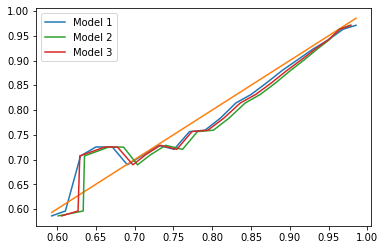

In [17]:
pred = []
act = []
pred2 = []
pred3 = []

for i in range(21):
    min = .58 + i*.02
    max = .58 + (i+1)*.02
    df = test[(test['pred'] >= min)&(test['pred'] < max)]
    pred_compliance = df['pred'].mean()
    act_compliance = df['target'].mean()
    pred.append(pred_compliance)
    pred2.append(df['pred2'].mean())
    pred3.append(df['pred3'].mean())
    act.append(act_compliance)
    #print('{} to {}:'.format(round(min,2), round(max,2)))
    #print('sample size: {}'.format(df.shape[0]))
    #print('predicted %: {}'.format(round(pred_compliance, 3)))
    #print('actual %:    {}'.format(round(act_compliance, 3)))
    #print('')
    
plt.plot(pred, act, label='Model 1')
plt.plot(pred, pred)
plt.plot(pred2, act, label='Model 2')
plt.plot(pred3, act, label='Model 3')
plt.legend()
plt.show()

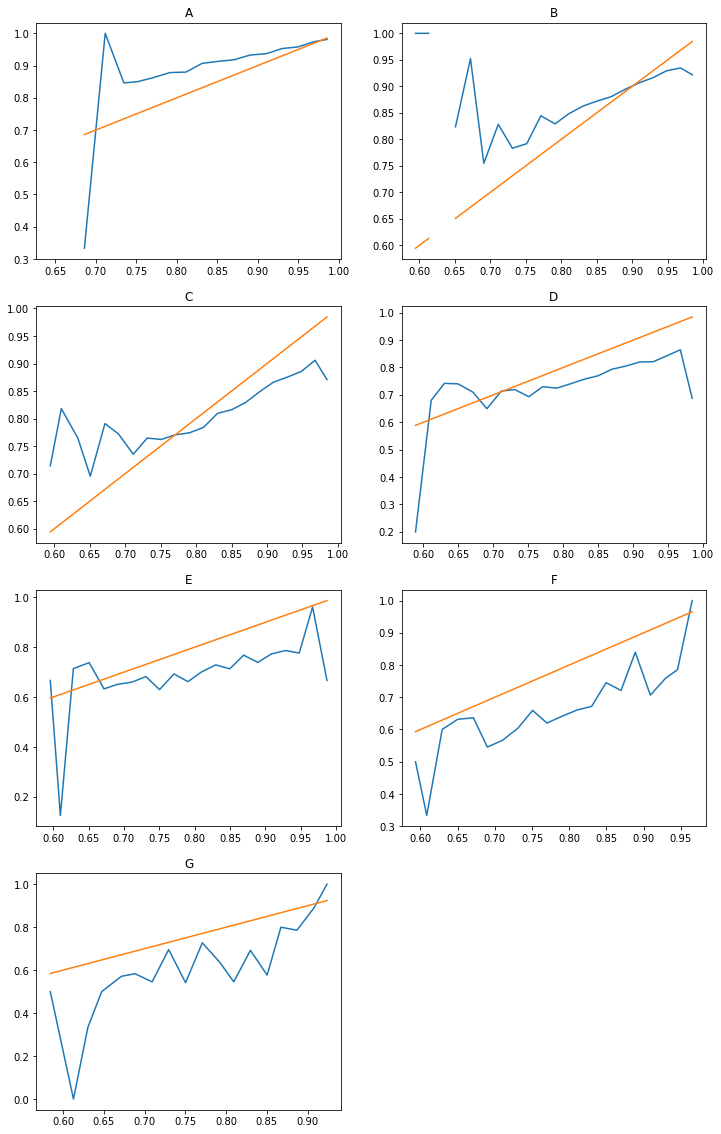

In [18]:
pred = []
act = []
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

plt.figure(figsize = (12,20))

for letter in range(7):
    pred = []
    act = []
    for i in range(21):
        min = .58 + i*.02
        max = .58 + (i+1)*.02
        df = test[(test['pred'] >= min)&(test['pred'] < max)&(test['grade']==letters[letter])]
        pred_compliance = df['pred'].mean()
        act_compliance = df['target'].mean()
        pred.append(pred_compliance)
        act.append(act_compliance)
    
    plt.subplot(4,2,letter+1)
    plt.title(letters[letter])
    plt.plot(pred, act)
    plt.plot(pred, pred)
plt.show()

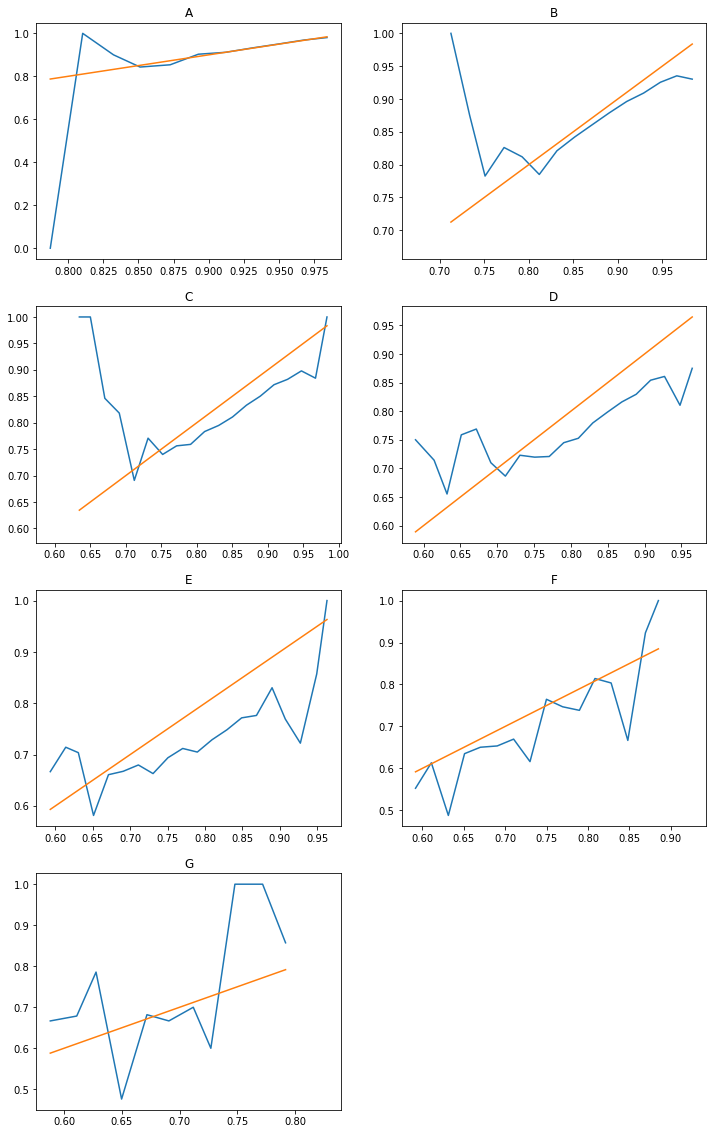

In [19]:
pred = []
act = []
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

plt.figure(figsize = (12,20))

for letter in range(7):
    pred = []
    act = []
    for i in range(21):
        min = .58 + i*.02
        max = .58 + (i+1)*.02
        df = test[(test['pred2'] >= min)&(test['pred2'] < max)&(test['grade']==letters[letter])]
        pred_compliance = df['pred2'].mean()
        act_compliance = df['target'].mean()
        pred.append(pred_compliance)
        act.append(act_compliance)
    
    plt.subplot(4,2,letter+1)
    plt.title(letters[letter])
    plt.plot(pred, act)
    plt.plot(pred, pred)

plt.show()

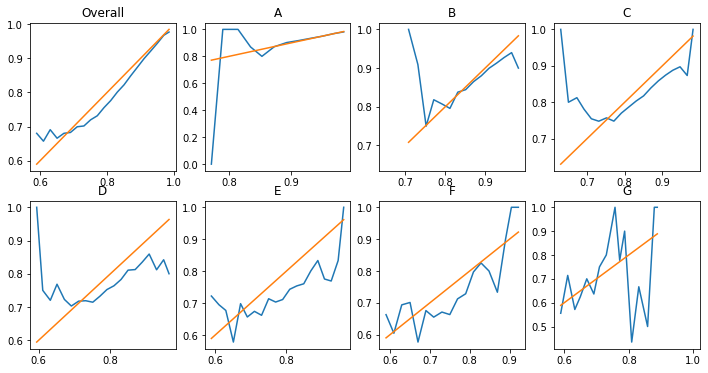

In [41]:
pred = []
act = []
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']



plt.figure(figsize = (12,6))
plt.subplot(2,4,1)
plt.title('Overall')

for i in range(21):
    lb = .58 + i*.02
    ub = .58 + (i+1)*.02
    df = test[(test['pred3'] >= lb)&(test['pred3'] < ub)]
    pred_compliance = df['pred3'].mean()
    act_compliance = df['target'].mean()
    pred.append(pred_compliance)
    act.append(act_compliance)
plt.plot(pred, act)
plt.plot(pred, pred)

for letter in range(7):
    pred = []
    act = []
    ss = []
    for i in range(21):
        lb = .58 + i*.02
        ub = .58 + (i+1)*.02
        df = test[(test['pred3'] >= lb)&(test['pred3'] < ub)&(test['grade']==letters[letter])]
        pred_compliance = df['pred3'].mean()
        act_compliance = df['target'].mean()
        pred.append(pred_compliance)
        act.append(act_compliance)
    
    plt.subplot(2,4,letter+2)
    plt.title(letters[letter])
    plt.plot(pred, act)
    plt.plot(pred, pred)

plt.show()

In [40]:
ss

[122,
 178,
 275,
 470,
 804,
 1384,
 2479,
 4088,
 6342,
 9323,
 13041,
 17122,
 21309,
 25559,
 30042,
 33757,
 36221,
 34554,
 27176,
 16316,
 2339]

In [21]:
sum(test[test.pred >= .98]['target'])/len(test[test.pred >= .98]['target'])

0.9711538461538461

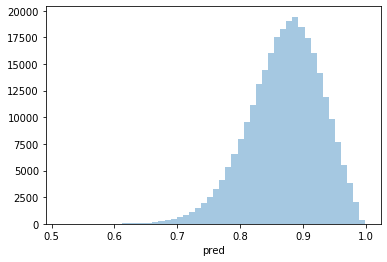

In [22]:
sns.distplot(test['pred'], kde=False)

In [29]:
test['pred']

235833     0.905414
236722     0.935686
236789     0.865715
236812     0.830383
237037     0.742080
237051     0.845376
237072     0.841004
237121     0.923701
237146     0.894683
237155     0.815985
237197     0.855380
237232     0.882663
237238     0.894412
237250     0.931999
237273     0.828965
237279     0.869456
237334     0.796146
237386     0.867553
237409     0.769772
237426     0.880721
237432     0.914517
237435     0.858918
237460     0.871885
237498     0.880551
237544     0.914093
237564     0.878109
237641     0.818316
237657     0.842235
237667     0.815849
237682     0.846504
             ...   
1352652    0.872016
1352653    0.875804
1352654    0.921670
1352655    0.883045
1352656    0.666255
1352657    0.873911
1352659    0.926325
1352660    0.860223
1352661    0.924769
1352662    0.817338
1352663    0.843260
1352664    0.927668
1352665    0.890451
1352666    0.878481
1352667    0.799431
1352668    0.853780
1352669    0.963612
1352670    0.916864
1352671    0.805732


In [42]:
test['pct_return'] = (test.total_pymnt - test.funded_amnt) / test.funded_amnt

for letter in letters:
    thresh_m1_80 = np.percentile(test[test.grade == letter]['pred'], q=80)
    thresh_m2_80 = np.percentile(test[test.grade == letter]['pred2'], q=80)
    thresh_m3_80 = np.percentile(test[test.grade == letter]['pred3'], q=80)

    thresh_m1_90 = np.percentile(test[test.grade == letter]['pred'], q=90)
    thresh_m2_90 = np.percentile(test[test.grade == letter]['pred2'], q=90)
    thresh_m3_90 = np.percentile(test[test.grade == letter]['pred3'], q=90)

    thresh_m1_95 = np.percentile(test[test.grade == letter]['pred'], q=95)
    thresh_m2_95 = np.percentile(test[test.grade == letter]['pred2'], q=95)
    thresh_m3_95 = np.percentile(test[test.grade == letter]['pred3'], q=95)
    
    thresh_m1_99 = np.percentile(test[test.grade == letter]['pred'], q=99)
    thresh_m2_99 = np.percentile(test[test.grade == letter]['pred2'], q=99)
    thresh_m3_99 = np.percentile(test[test.grade == letter]['pred3'], q=99)

    print('-----------------  ' + letter + '  -----------------')
    print('')
    
    print('Naive Returns:       {}'.format(test[test.grade==letter]['pct_return'].mean()*100))
    
    print('')
    print('Model 1:')
    print('>80th percentile:    {}'.format(test[(test.grade==letter)&(test.pred >= thresh_m1_80)]['pct_return'].mean()*100))
    print('>90th percentile:    {}'.format(test[(test.grade==letter)&(test.pred >= thresh_m1_90)]['pct_return'].mean()*100))
    print('>95th percentile:    {}'.format(test[(test.grade==letter)&(test.pred >= thresh_m1_95)]['pct_return'].mean()*100))
    print('>99th percentile:    {}'.format(test[(test.grade==letter)&(test.pred >= thresh_m1_99)]['pct_return'].mean()*100))
    print('')
    
    print('Model 2:')
    print('>80th percentile:    {}'.format(test[(test.grade==letter)&(test.pred2 >= thresh_m2_80)]['pct_return'].mean()*100))
    print('>90th percentile:    {}'.format(test[(test.grade==letter)&(test.pred2 >= thresh_m2_90)]['pct_return'].mean()*100))
    print('>95th percentile:    {}'.format(test[(test.grade==letter)&(test.pred2 >= thresh_m2_95)]['pct_return'].mean()*100))
    print('>99th percentile:    {}'.format(test[(test.grade==letter)&(test.pred2 >= thresh_m2_99)]['pct_return'].mean()*100))
    print('')
    
    print('Model 3:')
    print('>80th percentile:    {}'.format(test[(test.grade==letter)&(test.pred3 >= thresh_m3_80)]['pct_return'].mean()*100))
    print('>90th percentile:    {}'.format(test[(test.grade==letter)&(test.pred3 >= thresh_m3_90)]['pct_return'].mean()*100))
    print('>95th percentile:    {}'.format(test[(test.grade==letter)&(test.pred3 >= thresh_m3_95)]['pct_return'].mean()*100))
    print('>99th percentile:    {}'.format(test[(test.grade==letter)&(test.pred3 >= thresh_m3_99)]['pct_return'].mean()*100))

    print('\n')

-----------------  A  -----------------

Naive Returns:       7.141438714524952

Model 1:
>80th percentile:    7.269034917922852
>90th percentile:    7.211869610040597
>95th percentile:    7.057863168693489
>99th percentile:    7.402970790813831

Model 2:
>80th percentile:    7.313551703288275
>90th percentile:    7.189076981436527
>95th percentile:    7.162483211360746
>99th percentile:    7.180714447933194

Model 3:
>80th percentile:    7.081996207460708
>90th percentile:    7.0033454143282885
>95th percentile:    6.961256087802719
>99th percentile:    6.859826200391115


-----------------  B  -----------------

Naive Returns:       8.71693709483582

Model 1:
>80th percentile:    9.36116907962835
>90th percentile:    9.276675907039149
>95th percentile:    9.11696804227528
>99th percentile:    8.98584225673737

Model 2:
>80th percentile:    8.978270271342803
>90th percentile:    9.064982483780035
>95th percentile:    9.0500400604246
>99th percentile:    9.696492848076856

Model 3:
>80

Almost every model outperformed random selection by subclass. In most cases, restricting selection to a more narrow percentile increased our profitability.

The one exception is our third model on G-rated loans. Our training sample consists of 66 G-rated loans, and this is separated into 5 subclasses. Our estimate of the marginal fixed effect varies widely, and not in a linear manner as one would expect. It is fairly obviously an overfit model in this area of our sample, and thus, not surprising that our model did not perform well when selecting assets in this area.

In [ ]:
np.percentile(test[test.grade == 'A']['pred'], q=90)

In [ ]:
for i in test.columns:
    print(i)

In [47]:
import model_class

newmodel = Model(sm.Probit(), y, X2)

NameError: name 'Model' is not defined